# Day 8-9: nnsight Setup with Qwen

**Goal:** Learn nnsight fundamentals and verify setup with a probe verification exercise

**Learning Objectives:**
1. Understand why we're transitioning from TransformerLens to nnsight
2. Load and interact with Qwen2.5-7B-Instruct using nnsight
3. Extract activations from any layer
4. Perform basic interventions (activation patching)
5. Verify setup works by training a sentiment probe

**Timeline:** 6-7 hours

**Environment:** Vast.ai with GPU (16GB+ VRAM recommended)

---

## Why nnsight Instead of TransformerLens?

In Days 3-6, you used **TransformerLens** with GPT-2 to learn probing fundamentals. Now we're switching to **nnsight** for your actual CoT faithfulness research.

**The key difference:**

| Aspect | TransformerLens | nnsight |
|--------|-----------------|--------|
| **Model support** | GPT-2, GPT-Neo, limited models | ANY HuggingFace model |
| **Qwen/Llama/DeepSeek** | NOT SUPPORTED | Fully supported |
| **CoT reasoning models** | Cannot use | Required for this |
| **Best use case** | Learning mech interp basics | Production research on modern models |

**Bottom line:** TransformerLens doesn't support Qwen, Llama, or other modern reasoning models. For CoT faithfulness research, you MUST use nnsight (or similar tools like nnsight).

GPT-2 doesn't do meaningful chain-of-thought reasoning - it's too small. You need a model like Qwen2.5-7B-Instruct that actually reasons through problems.

---

## Part 1: Environment Setup & Installation

In [4]:
# Install required packages (run this first on a fresh Vast.ai instance)
# Uncomment and run if packages aren't installed
import sys

# For individual package installs
!{sys.executable} -m pip install -q nnsight transformers accelerate matplotlib pandas scikit-learn

# Or from requirements file
#!{sys.executable} -m pip install -q -r requirements.txt

print("Setup complete!")

Setup complete!


In [1]:
# Verify GPU is available
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU detected! This notebook requires a GPU.")
    print("If on Vast.ai, make sure you selected a GPU instance.")

PyTorch version: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3090 Ti
GPU Memory: 25.3 GB


In [3]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# nnsight - the key library for this notebook
from nnsight import LanguageModel

print("All imports successful!")

All imports successful!


---

## Part 2: Loading Qwen with nnsight

In [4]:
# Load Qwen2.5-7B-Instruct with nnsight
# This will download the model on first run (~14GB)

print("Loading Qwen2.5-7B-Instruct... (this may take a few minutes on first run)")

model = LanguageModel(
    "Qwen/Qwen2.5-7B-Instruct",
    device_map="auto",  # Automatically place on GPU
    torch_dtype=torch.float16  # Use half precision to save memory
)

print("Model loaded successfully!")

Loading Qwen2.5-7B-Instruct... (this may take a few minutes on first run)


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model loaded successfully!


In [5]:
# Explore the model architecture
# This is DIFFERENT from TransformerLens - we're working with HuggingFace structure

print("Model Architecture:")
print("=" * 50)
print(model)

Model Architecture:
Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,)

In [6]:
# Key model properties for Qwen2.5-7B
# Access the underlying HuggingFace model config

config = model.config
print(f"Model: {config.model_type}")
print(f"Hidden size (d_model): {config.hidden_size}")
print(f"Number of layers: {config.num_hidden_layers}")
print(f"Number of attention heads: {config.num_attention_heads}")
print(f"Vocabulary size: {config.vocab_size}")

Model: qwen2
Hidden size (d_model): 3584
Number of layers: 28
Number of attention heads: 28
Vocabulary size: 152064


### Key Structural Differences from TransformerLens

| TransformerLens (GPT-2) | nnsight (Qwen) |
|------------------------|----------------|
| `model.blocks[i]` | `model.model.layers[i]` |
| `cache["resid_post", layer]` | `model.model.layers[layer].output[0]` |
| 12 layers, 768 hidden | 28 layers, 3584 hidden |
| Automatic caching | Explicit `.save()` required |

The nnsight library wraps the HuggingFace model, so we access layers through `model.model.layers[i]`.

---

## Part 3: Basic Tracing - Saving Activations

The core concept in nnsight is the **trace context**. Inside a `with model.trace()` block:
- Operations create "proxy" objects
- Nothing executes until the context exits
- Use `.save()` to preserve values you want to access later

In [7]:
# Simplest example: save hidden states at one layer

with model.trace("Hello, world!"):
    # Access layer 14 (middle of the 28 layers)
    # .output[0] gets the hidden states (first element of output tuple)
    hidden_states = model.model.layers[14].output[0].save()

# After the context exits, hidden_states contains the tensor directly
# NOTE: nnsight returns [seq_len, hidden_size] - no batch dimension
print(f"Hidden states shape: {hidden_states.shape}")
print(f"Expected: [seq_len, hidden_size={config.hidden_size}]")

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

AttributeError: 'Tensor' object has no attribute 'value'

In [9]:
# Understanding the shape:
# - No batch dimension (nnsight squeezes it out for single inputs)
# - Sequence length (number of tokens in "Hello, world!")
# - Hidden dimension (3584 for Qwen2.5-7B)

# Let's check the tokenization
tokens = model.tokenizer.encode("Hello, world!")
print(f"Tokens: {tokens}")
print(f"Token strings: {[model.tokenizer.decode([t]) for t in tokens]}")
print(f"Number of tokens: {len(tokens)}")

Type of hidden_states: <class 'torch.Tensor'>
Hidden states shape: torch.Size([4, 3584])
Expected: [batch=1, seq_len, hidden_size=3584]


In [12]:
# Save activations at MULTIPLE layers

layers_to_extract = [0, 7, 14, 21, 27]  # Early, mid, late layers
saved_activations = {}

with model.trace("The capital of France is Paris."):
    for layer in layers_to_extract:
        saved_activations[layer] = model.model.layers[layer].output[0].save()

# Check shapes - no .value needed, no batch dimension
print("Activations at each layer:")
for layer, acts in saved_activations.items():
    print(f"  Layer {layer:2d}: shape = {acts.shape}")

Activations at each layer:
  Layer  0: shape = torch.Size([7, 3584])
  Layer  7: shape = torch.Size([7, 3584])
  Layer 14: shape = torch.Size([7, 3584])
  Layer 21: shape = torch.Size([7, 3584])
  Layer 27: shape = torch.Size([7, 3584])


In [14]:
# Helper function: Extract final token activation at specified layer
# This mirrors what we did in TransformerLens

def get_final_token_activation_nnsight(model, text, layer):
    """
    Extract the activation of the final token at a specified layer.
    
    Args:
        model: nnsight LanguageModel
        text: Input string
        layer: Layer number (0 to num_layers-1)
    
    Returns:
        numpy array of shape (hidden_size,)
    """
    with model.trace(text):
        hidden = model.model.layers[layer].output[0].save()
    
    # No .value needed, shape is [seq_len, hidden_size] (no batch dim)
    # Need .detach() before .numpy() since tensor has grad
    final_act = hidden[-1, :].detach().cpu().numpy()
    return final_act

# Test it
test_act = get_final_token_activation_nnsight(model, "Test sentence.", layer=14)
print(f"Activation shape: {test_act.shape}")
print(f"Expected: ({config.hidden_size},)")

Activation shape: (3584,)
Expected: (3584,)


### Comparison: TransformerLens vs nnsight Activation Extraction

**TransformerLens:**
```python
_, cache = model.run_with_cache(text)
activation = cache["resid_post", layer][0, -1, :].cpu().numpy()
```

**nnsight (current API):**
```python
with model.trace(text):
    hidden = model.model.layers[layer].output[0].save()
activation = hidden[-1, :].detach().cpu().numpy()  # No .value, no batch dim
```

Key differences:
1. nnsight requires explicit `.save()` - values aren't automatically cached
2. nnsight uses deferred execution - operations run when context exits
3. nnsight uses HuggingFace model structure (`model.model.layers`)
4. nnsight returns tensors directly (no `.value` accessor needed)
5. Shape is `[seq_len, hidden_size]` - no batch dimension
6. Need `.detach()` before `.numpy()` since tensors have gradients

---

## Part 3.5: Accessing Attention and MLP Components

In Day 5-6, you learned that different components (attention vs MLP) serve different computational roles:
- **Attention:** Routes information between positions ("where should I look?")
- **MLP:** Transforms information within position ("what should I compute?")

Here's how to access these components in nnsight (compared to TransformerLens).

In [15]:
# First, let's explore the structure of a single layer in Qwen
# This shows us what submodules we can access

print("Structure of layer 0:")
print("=" * 50)
for name, module in model.model.layers[0].named_children():
    print(f"  {name}: {type(module).__name__}")

Structure of layer 0:
  self_attn: Qwen2Attention
  mlp: Qwen2MLP
  input_layernorm: Qwen2RMSNorm
  post_attention_layernorm: Qwen2RMSNorm


In [27]:
# Access MLP output at a specific layer
# The MLP in Qwen is called "mlp" (in GPT-2/TransformerLens it was also "mlp")
#
# IMPORTANT: In nnsight, you should access different component types in SEPARATE traces
# Mixing layer output and submodule output in one trace can cause OutOfOrderError

# Get MLP output in its own trace
with model.trace("The capital of France is Paris."):
   mlp_output = model.model.layers[14].mlp.output.save()

# Get layer output in a separate trace
with model.trace("The capital of France is Paris."):
   layer_output = model.model.layers[14].output[0].save()

print(f"MLP output shape: {mlp_output.shape}")
print(f"Layer output shape: {layer_output.shape}")
print(f"\nBoth should have hidden_size={config.hidden_size} as last dimension")

MLP output shape: torch.Size([1, 7, 3584])
Layer output shape: torch.Size([7, 3584])

Both should have hidden_size=3584 as last dimension


In [22]:
# Access Attention output at a specific layer
# In Qwen, the self-attention module is called "self_attn"

with model.trace("The capital of France is Paris."):
    # Get the attention output (after attention computation, before adding to residual)
    # Note: attention output is typically a tuple, we want the first element
    attn_output = model.model.layers[14].self_attn.output[0].save()

# No .value needed
# NOTE: Attention output DOES have batch dimension: [batch, seq_len, hidden_size]
# This is different from layer output which has no batch dim!
print(f"Attention output shape: {attn_output.shape}")
print(f"Expected: [1, seq_len, hidden_size={config.hidden_size}]")
print(f"\nNote: self_attn.output includes batch dim, but layers[].output[0] does not!")

Attention output shape: torch.Size([1, 7, 3584])
Expected: [1, seq_len, hidden_size=3584]

Note: self_attn.output includes batch dim, but layers[].output[0] does not!


In [23]:
# Access Attention PATTERNS (the attention weights after softmax)
# 
# NOTE: This requires "eager" attention implementation, but modern models
# default to SDPA (Scaled Dot Product Attention) for speed.
# 
# For probing, we usually care about attention OUTPUT (the result), not
# the attention PATTERNS (the weights). We already have the output!
#
# If you need patterns for visualization/analysis, you'd need to reload
# the model with: attn_implementation="eager" (but this is slower)

# Let's verify what attention implementation we're using:
print(f"Attention implementation: {model.config._attn_implementation}")
print(f"\nWith '{model.config._attn_implementation}' attention:")
print("  ✓ Can access attention OUTPUT (what we need for probing)")
print("  ✗ Cannot access attention PATTERNS (weights after softmax)")
print("\nThis is fine for faithfulness probing - we probe the outputs, not the weights!")

Attention implementation: sdpa

With 'sdpa' attention:
  ✓ Can access attention OUTPUT (what we need for probing)
  ✗ Cannot access attention PATTERNS (weights after softmax)

This is fine for faithfulness probing - we probe the outputs, not the weights!


In [24]:
# OPTIONAL: If you really need attention patterns, you can reload with eager attention
# This is SLOWER but allows accessing the attention weights
#
# Uncomment below ONLY if you need attention pattern visualization:
#
# model_eager = LanguageModel(
#     "Qwen/Qwen2.5-7B-Instruct",
#     device_map="auto",
#     torch_dtype=torch.float16,
#     attn_implementation="eager"  # Enables output_attentions
# )
#
# model_eager.config.output_attentions = True
# with model_eager.trace("The capital of France is Paris."):
#     attn_with_weights = model_eager.model.layers[14].self_attn.output.save()

# For this notebook, we'll skip attention patterns since:
# 1. We're focused on probing activation OUTPUTS
# 2. SDPA is much faster for training/inference
# 3. Attention patterns are mainly useful for interpretability visualization

print("Skipping attention pattern extraction (using fast SDPA attention)")
print("\nFor faithfulness probing, we need:")
print("  ✓ Layer outputs (residual stream) - AVAILABLE")  
print("  ✓ MLP outputs - AVAILABLE")
print("  ✓ Attention outputs - AVAILABLE")
print("  - Attention patterns (weights) - Not needed for probing")

Skipping attention pattern extraction (using fast SDPA attention)

For faithfulness probing, we need:
  ✓ Layer outputs (residual stream) - AVAILABLE
  ✓ MLP outputs - AVAILABLE
  ✓ Attention outputs - AVAILABLE
  - Attention patterns (weights) - Not needed for probing


In [25]:
# Helper functions for extracting different components
# Updated for current nnsight API:
# - No .value accessor needed
# - Need .detach() before .numpy()
# - IMPORTANT: Different modules have different batch dimension behavior:
#   * layers[].output[0]: NO batch dim - shape [seq_len, hidden_size]
#   * mlp.output: NO batch dim - shape [seq_len, hidden_size]
#   * self_attn.output[0]: HAS batch dim - shape [batch, seq_len, hidden_size]

def get_mlp_output(model, text, layer, position='last'):
    """
    Extract MLP output at a specific layer.
    
    Args:
        model: nnsight LanguageModel
        text: Input string
        layer: Layer number
        position: 'last', 'first', 'mean', or int
    
    Returns:
        numpy array of shape (hidden_size,)
    """
    with model.trace(text):
        mlp_out = model.model.layers[layer].mlp.output.save()
    
    # MLP output has NO batch dim - shape is [seq_len, hidden_size]
    acts = mlp_out
    
    if position == 'last':
        return acts[-1, :].detach().cpu().numpy()
    elif position == 'first':
        return acts[0, :].detach().cpu().numpy()
    elif position == 'mean':
        return acts.mean(dim=0).detach().cpu().numpy()
    elif isinstance(position, int):
        return acts[position, :].detach().cpu().numpy()


def get_attention_output(model, text, layer, position='last'):
    """
    Extract attention output at a specific layer.
    
    Args:
        model: nnsight LanguageModel
        text: Input string  
        layer: Layer number
        position: 'last', 'first', 'mean', or int
    
    Returns:
        numpy array of shape (hidden_size,)
    """
    with model.trace(text):
        attn_out = model.model.layers[layer].self_attn.output[0].save()
    
    # Attention output HAS batch dim - shape is [batch, seq_len, hidden_size]
    # Index with [0] to remove batch dimension first
    acts = attn_out[0]  # Now [seq_len, hidden_size]
    
    if position == 'last':
        return acts[-1, :].detach().cpu().numpy()
    elif position == 'first':
        return acts[0, :].detach().cpu().numpy()
    elif position == 'mean':
        return acts.mean(dim=0).detach().cpu().numpy()
    elif isinstance(position, int):
        return acts[position, :].detach().cpu().numpy()


def get_attention_patterns(model, text, layer):
    """
    Extract attention patterns (weights after softmax) at a specific layer.
    
    NOTE: This only works if the model uses "eager" attention implementation.
    With SDPA (default for speed), attention patterns are not available.
    
    Args:
        model: nnsight LanguageModel
        text: Input string
        layer: Layer number
    
    Returns:
        numpy array of shape (num_heads, seq_len, seq_len) or None
    """
    # Check if we can access attention patterns
    if hasattr(model.config, '_attn_implementation'):
        if model.config._attn_implementation != "eager":
            # Can't get patterns with SDPA/flash attention
            return None
    
    # Try to enable attention output
    try:
        original = model.config.output_attentions
        model.config.output_attentions = True
        
        with model.trace(text):
            attn_out = model.model.layers[layer].self_attn.output.save()
        
        model.config.output_attentions = original
        
        # Attention weights are typically the second element of the tuple
        if isinstance(attn_out, tuple) and len(attn_out) > 1:
            patterns = attn_out[1]
            if patterns is not None:
                # Remove batch dim if present
                if len(patterns.shape) == 4:
                    patterns = patterns[0]
                return patterns.detach().cpu().numpy()
    except ValueError:
        # SDPA doesn't support output_attentions
        pass
    
    return None


# Test the helper functions
print("Testing component extraction functions:")
print("=" * 50)

test_mlp = get_mlp_output(model, "Test sentence.", layer=14, position='last')
print(f"MLP output shape: {test_mlp.shape}")

test_attn = get_attention_output(model, "Test sentence.", layer=14, position='last')
print(f"Attention output shape: {test_attn.shape}")

test_patterns = get_attention_patterns(model, "Test sentence.", layer=14)
if test_patterns is not None:
    print(f"Attention patterns shape: {test_patterns.shape}")
else:
    print("Attention patterns: Not available (model uses SDPA - this is expected)")

Testing component extraction functions:
MLP output shape: (3, 3584)
Attention output shape: (3584,)
Attention patterns: Not available (model uses SDPA - this is expected)


### Component Access Comparison: TransformerLens vs nnsight

| Component | TransformerLens | nnsight (Qwen) |
|-----------|-----------------|----------------|
| **Residual stream (layer output)** | `cache["resid_post", layer]` | `model.model.layers[layer].output[0]` |
| **MLP output** | `cache["blocks.{layer}.hook_mlp_out"]` | `model.model.layers[layer].mlp.output` |
| **Attention output** | `cache["attn_out", layer]` | `model.model.layers[layer].self_attn.output[0]` |
| **Attention patterns** | `cache["blocks.{layer}.attn.hook_pattern"]` | Enable `output_attentions=True`, then `self_attn.output[1]` |
| **Individual head outputs** | `cache["blocks.{layer}.attn.hook_z"]` | Requires accessing internal attention computation |

**Key insight from Day 5-6:** You found that middle-layer attention heads outperformed residual stream probes for sentiment. With these extraction functions, you can    
test if the same pattern holds for Qwen and for faithfulness detection.

**Important nnsight limitations:**
1. **Shape differences:** `layers[].output[0]` and `mlp.output` have NO batch dimension `[seq_len, hidden_size]`, but `self_attn.output[0]` HAS batch dimension
`[batch, seq_len, hidden_size]`
2. **Separate traces required:** You must extract different component types (layer output vs mlp vs attention) in SEPARATE `model.trace()` calls. Mixing them in one     
trace causes `OutOfOrderError`.

In [28]:
# Quick comparison: Residual vs MLP vs Attention at the same layer
# This mirrors the analysis you did in Day 5-6
#
# IMPORTANT: Extract each component in a SEPARATE trace to avoid OutOfOrderError

test_text = "I love this movie!"
layer = 14

# Extract each component in its own trace
with model.trace(test_text):
   residual = model.model.layers[layer].output[0].save()

with model.trace(test_text):
   mlp = model.model.layers[layer].mlp.output.save()

with model.trace(test_text):
   attn = model.model.layers[layer].self_attn.output[0].save()

# Get final token activations
# Note the different indexing due to batch dimension differences:
# - residual & mlp: [seq_len, hidden_size] - no batch dim
# - attn: [batch, seq_len, hidden_size] - has batch dim
residual_act = residual[-1, :].detach().cpu().numpy()
mlp_act = mlp[-1, :].detach().cpu().numpy()
attn_act = attn[0, -1, :].detach().cpu().numpy()  # [0] removes batch dim

print(f"Component activations at layer {layer}, final token:")
print(f"  Residual stream: norm = {np.linalg.norm(residual_act):.2f}")
print(f"  MLP output:      norm = {np.linalg.norm(mlp_act):.2f}")
print(f"  Attention output: norm = {np.linalg.norm(attn_act):.2f}")

# Note: residual ≈ previous_residual + attention + mlp
# So residual has accumulated information from both components

Component activations at layer 14, final token:
  Residual stream: norm = 72.38
  MLP output:      norm = 57.97
  Attention output: norm = 15.50


---

## Part 4: Generation with Activation Access

For CoT faithfulness research, you need to:
1. Generate reasoning (multi-token output)
2. Access activations during that generation

nnsight uses `.generate()` for this.

In [33]:
# Generate text with activation access
# 
# NOTE: The nnsight generation API has changed. We need to use a different approach.
# For now, let's generate text and extract activations separately.

prompt = "What is 17 * 23? Let me think step by step."

# Tokenize the prompt with attention mask
inputs = model.tokenizer(prompt, return_tensors="pt", return_attention_mask=True)
input_ids = inputs["input_ids"].to(model.device)
attention_mask = inputs["attention_mask"].to(model.device)

# Generate using the model directly (greedy decoding)
with torch.no_grad():
   output_ids = model.generate(
       input_ids,
       attention_mask=attention_mask,
       max_new_tokens=150,
       do_sample=False,  # Greedy decoding
       pad_token_id=model.tokenizer.eos_token_id  # Suppress padding warning
   )

# Decode the output
output_text = model.tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Generated text:")
print("=" * 50)
print(output_text)
print("=" * 50)

# Now extract activations for the full sequence (prompt + generated)
with model.trace(output_text):
   hidden_during_gen = model.model.layers[14].output[0].save()

print(f"\nActivations shape: {hidden_during_gen.shape}")
print(f"This represents activations for the full generated sequence.")

Generated text:
What is 17 * 23? Let me think step by step. To solve 17 * 23, I'll use the standard multiplication algorithm:

Step 1: Multiply 23 by 7 (the ones digit of 17)
23 * 7 = 161

Step 2: Multiply 23 by 1 (the tens digit of 17), and remember to shift one place to the left
23 * 10 = 230

Step 3: Add the results from steps 1 and 2
161 + 230 = 391

Therefore, 17 * 23 = 391. 

You can verify this by using a calculator or another method of multiplication.

Activations shape: torch.Size([167, 3584])
This represents activations for the full generated sequence.


In [31]:
# Understanding the activation shape during generation:
# Shape is [total_sequence_length, hidden_size] (no batch dim)
# total_sequence_length = prompt_tokens + generated_tokens

prompt_tokens = model.tokenizer.encode(prompt)
total_tokens = model.tokenizer.encode(output_text)
print(f"Prompt tokens: {len(prompt_tokens)}")
print(f"Total tokens (prompt + generated): {len(total_tokens)}")
print(f"Activation sequence length: {hidden_during_gen.shape[0]}")
print(f"Generated tokens: {len(total_tokens) - len(prompt_tokens)}")

Prompt tokens: 17
Total tokens (prompt + generated): 167
Activation sequence length: 167
Generated tokens: 150


In [32]:
# Map tokens to their activations
# This is important for position analysis in faithfulness research

all_token_ids = model.tokenizer.encode(output_text)
all_tokens = [model.tokenizer.decode([t]) for t in all_token_ids]

print("Token-Activation mapping (first 20 tokens):")
print("-" * 60)
for i, (tok_id, tok_str) in enumerate(zip(all_token_ids[:20], all_tokens[:20])):
   # No batch dim, so index directly with position
   act_norm = hidden_during_gen[i, :].norm().item()
   print(f"Pos {i:3d}: '{tok_str:15s}' | Activation norm: {act_norm:.2f}")

Token-Activation mapping (first 20 tokens):
------------------------------------------------------------
Pos   0: 'What           ' | Activation norm: 15120.00
Pos   1: ' is            ' | Activation norm: 89.25
Pos   2: '               ' | Activation norm: 88.12
Pos   3: '1              ' | Activation norm: 79.38
Pos   4: '7              ' | Activation norm: 77.88
Pos   5: ' *             ' | Activation norm: 66.94
Pos   6: '               ' | Activation norm: 72.44
Pos   7: '2              ' | Activation norm: 69.81
Pos   8: '3              ' | Activation norm: 69.56
Pos   9: '?              ' | Activation norm: 70.38
Pos  10: ' Let           ' | Activation norm: 62.34
Pos  11: ' me            ' | Activation norm: 64.50
Pos  12: ' think         ' | Activation norm: 66.31
Pos  13: ' step          ' | Activation norm: 65.00
Pos  14: ' by            ' | Activation norm: 68.38
Pos  15: ' step          ' | Activation norm: 64.44
Pos  16: '.              ' | Activation norm: 56.22
Pos  17:

---

## Part 5: Intervention Basics

Beyond reading activations, nnsight lets you **modify** them during forward pass. This is activation patching.

In [35]:
# Simple intervention: zero out the last token's activation at layer 10
#
# NOTE: With the current nnsight API, interventions during generation are complex.
# Instead, we'll demonstrate intervention during a forward pass (trace).

prompt = "The capital of France is"

# Tokenize
inputs = model.tokenizer(prompt, return_tensors="pt", return_attention_mask=True)
input_ids = inputs["input_ids"].to(model.device)
attention_mask = inputs["attention_mask"].to(model.device)

# Baseline generation (no intervention)
with torch.no_grad():
   baseline_ids = model.generate(
       input_ids,
       attention_mask=attention_mask,
       max_new_tokens=5,
       do_sample=False,
       pad_token_id=model.tokenizer.eos_token_id
   )

baseline_output = model.tokenizer.decode(baseline_ids[0], skip_special_tokens=True)
print(f"Baseline: {baseline_output}")

# For intervention, we can demonstrate with a trace (forward pass)
# This shows that we CAN modify activations, even if generation intervention is complex
print("\n--- Intervention Demo (Forward Pass) ---")

# Get logits WITHOUT intervention
with model.trace(prompt):
   clean_logits = model.lm_head.output.save()

# Get logits WITH intervention (zero out layer 10 last position)
with model.trace(prompt):
   # Zero out the last position at layer 10
   model.model.layers[10].output[0][-1, :] = 0
   intervened_logits = model.lm_head.output.save()

# Compare the top predicted tokens
clean_next_token = clean_logits[-1, :].argmax().item()
intervened_next_token = intervened_logits[-1, :].argmax().item()

print(f"Clean next token prediction: '{model.tokenizer.decode([clean_next_token])}'")
print(f"Intervened next token prediction: '{model.tokenizer.decode([intervened_next_token])}'")
print(f"Intervention changed prediction: {clean_next_token != intervened_next_token}")

Baseline: The capital of France is Paris. Which of the

--- Intervention Demo (Forward Pass) ---
Clean next token prediction: ''
Intervened next token prediction: ''
Intervention changed prediction: False


In [39]:
# Cross-prompt intervention (activation patching)
# Extract activation from one prompt, inject into another
#
# This demonstrates the core technique used in mechanistic interpretability:
# "What happens if we replace the representation of X with the representation of Y?"

source_prompt = "The capital of Germany is"
target_prompt = "The capital of France is"

# Step 1: Extract activation from source prompt
with model.trace(source_prompt):
   source_activation = model.model.layers[14].output[0].save()

print(f"Source activation shape: {source_activation.shape}")

# Step 2: Get clean prediction for target
with model.trace(target_prompt):
   clean_logits = model.lm_head.output.save()

print(f"Clean logits shape: {clean_logits.shape}")

# Get logits for the last token position - handle different possible shapes
if len(clean_logits.shape) == 3:
   # Shape is [batch, seq_len, vocab_size]
   clean_last_logits = clean_logits[0, -1, :]
elif len(clean_logits.shape) == 2:
   # Shape is [seq_len, vocab_size]
   clean_last_logits = clean_logits[-1, :]
else:
   clean_last_logits = clean_logits

print(f"Clean last logits shape: {clean_last_logits.shape}")

clean_next_token = clean_last_logits.argmax().item()
print(f"\nTarget prompt: '{target_prompt}'")
print(f"Clean next token: '{model.tokenizer.decode([clean_next_token])}'")

# Step 3: Patch source activation into target and get new prediction
with model.trace(target_prompt):
   # Replace layer 14 activation with source activation
   model.model.layers[14].output[0][:, :] = source_activation
   patched_logits = model.lm_head.output.save()

# Handle different possible shapes
if len(patched_logits.shape) == 3:
   patched_last_logits = patched_logits[0, -1, :]
elif len(patched_logits.shape) == 2:
   patched_last_logits = patched_logits[-1, :]
else:
   patched_last_logits = patched_logits

patched_next_token = patched_last_logits.argmax().item()
print(f"Patched next token: '{model.tokenizer.decode([patched_next_token])}'")
print(f"\nPatching changed prediction: {clean_next_token != patched_next_token}")

# Show top-5 predictions for both
print("\n--- Top-5 Predictions Comparison ---")
clean_probs = torch.softmax(clean_last_logits.float(), dim=-1)
patched_probs = torch.softmax(patched_last_logits.float(), dim=-1)

# Get top 5 - flatten to ensure 1D
clean_probs_flat = clean_probs.flatten()
patched_probs_flat = patched_probs.flatten()

clean_top5_vals, clean_top5_idxs = clean_probs_flat.topk(5)
patched_top5_vals, patched_top5_idxs = patched_probs_flat.topk(5)

print(f"Top5 vals shape: {clean_top5_vals.shape}")

print("Clean (France prompt):")
for i in range(5):
   prob = clean_top5_vals[i].detach().cpu().item()
   idx = clean_top5_idxs[i].detach().cpu().item()
   print(f"  {i+1}. '{model.tokenizer.decode([idx])}' ({prob:.2%})")

print("\nPatched (with Germany activations):")
for i in range(5):
   prob = patched_top5_vals[i].detach().cpu().item()
   idx = patched_top5_idxs[i].detach().cpu().item()
   print(f"  {i+1}. '{model.tokenizer.decode([idx])}' ({prob:.2%})")

# Note: The immediate next token might just be a space or punctuation.
# The real test is whether "Paris" vs "Berlin" probability shifts.
print("\n--- Specific Token Probability Comparison ---")
paris_id = model.tokenizer.encode(" Paris", add_special_tokens=False)[0]
berlin_id = model.tokenizer.encode(" Berlin", add_special_tokens=False)[0]

print(f"P(' Paris') - Clean: {clean_probs_flat[paris_id].item():.4%}, Patched: {patched_probs_flat[paris_id].item():.4%}")
print(f"P(' Berlin') - Clean: {clean_probs_flat[berlin_id].item():.4%}, Patched: {patched_probs_flat[berlin_id].item():.4%}")

Source activation shape: torch.Size([5, 3584])
Clean logits shape: torch.Size([1, 5, 152064])
Clean last logits shape: torch.Size([152064])

Target prompt: 'The capital of France is'
Clean next token: ' Paris'
Patched next token: ' Berlin'

Patching changed prediction: True

--- Top-5 Predictions Comparison ---
Top5 vals shape: torch.Size([5])
Clean (France prompt):
  1. ' Paris' (49.96%)
  2. ' __' (7.37%)
  3. ' a' (5.74%)
  4. ' ____' (4.83%)
  5. ' ______' (4.10%)

Patched (with Germany activations):
  1. ' Berlin' (31.35%)
  2. ' __' (11.72%)
  3. ' a' (10.92%)
  4. ' ______' (6.68%)
  5. ' ____' (5.28%)

--- Specific Token Probability Comparison ---
P(' Paris') - Clean: 49.9630%, Patched: 0.0066%
P(' Berlin') - Clean: 0.0257%, Patched: 31.3535%


### Comparison: TransformerLens vs nnsight Interventions

**TransformerLens (hook-based):**
```python
def hook_fn(activation, hook):
   activation[:, -1, :] = 0
   return activation

model.run_with_hooks(prompt, fwd_hooks=[("blocks.10.hook_resid_post", hook_fn)])
```

**nnsight (assignment-based):**
```python
with model.trace(prompt):
   model.model.layers[10].output[0][-1, :] = 0  # Note: no batch dim
   logits = model.lm_head.output.save()  # Get the resulting logits
```

nnsight's approach is more intuitive - you just assign to the values you want to change within the trace context.

**Key insight:** Activation patching lets us ask causal questions like:
- "Does the model's prediction change if we replace France's representation with Germany's?"
- "Which layer contains the 'country → capital' mapping?"

This is the foundation for understanding how CoT reasoning is represented internally.

---

## Part 6: Building Probe-Compatible Extraction Class

Let's build a reusable class that mirrors the ProbeToolkit from TransformerLens days.

In [40]:
class NNsightActivationExtractor:
    """
    Reusable toolkit for extracting activations from nnsight models.
    Mirrors the ProbeToolkit from TransformerLens exercises.
    
    Updated for current nnsight API:
    - No .value accessor needed (tensors returned directly)
    - No batch dimension in layer output (shape is [seq_len, hidden_size])
    - Need .detach() before .numpy() since tensors have grad
    """
    
    def __init__(self, model):
        self.model = model
        self.config = model.config
        self.num_layers = model.config.num_hidden_layers
        self.hidden_size = model.config.hidden_size
    
    def get_layer_activation(self, text, layer, position='last'):
        """
        Extract activation at a specific layer and position.
        
        Args:
            text: Input string
            layer: Layer number (0 to num_layers-1)
            position: 'last', 'first', 'mean', or int for specific position
        
        Returns:
            numpy array of shape (hidden_size,)
        """
        with self.model.trace(text):
            hidden = self.model.model.layers[layer].output[0].save()
        
        # No .value, no batch dim - shape is [seq_len, hidden_size]
        # Need .detach() before .numpy() since tensor has grad
        acts = hidden
        
        if position == 'last':
            return acts[-1, :].detach().cpu().numpy()
        elif position == 'first':
            return acts[0, :].detach().cpu().numpy()
        elif position == 'mean':
            return acts.mean(dim=0).detach().cpu().numpy()
        elif isinstance(position, int):
            return acts[position, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unknown position: {position}")
    
    def get_batch_activations(self, texts, layer, position='last'):
        """
        Extract activations for multiple texts.
        
        Args:
            texts: List of input strings
            layer: Layer number
            position: Position strategy
        
        Returns:
            numpy array of shape (n_texts, hidden_size)
        """
        activations = []
        for text in texts:
            act = self.get_layer_activation(text, layer, position)
            activations.append(act)
        return np.array(activations)
    
    def compare_layers(self, texts_pos, texts_neg, layers, position='last'):
        """
        Compare probe performance across multiple layers.
        
        Args:
            texts_pos: List of positive class texts
            texts_neg: List of negative class texts
            layers: List of layer numbers to test
            position: Position strategy
        
        Returns:
            DataFrame with layer, train_acc, test_acc
        """
        results = []
        
        for layer in layers:
            print(f"Testing layer {layer}...")
            
            # Extract activations
            X_pos = self.get_batch_activations(texts_pos, layer, position)
            X_neg = self.get_batch_activations(texts_neg, layer, position)
            
            # Combine into dataset
            X = np.vstack([X_pos, X_neg])
            y = np.array([1] * len(texts_pos) + [0] * len(texts_neg))
            
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=y
            )
            
            # Train probe
            probe = LogisticRegression(max_iter=1000, random_state=42)
            probe.fit(X_train, y_train)
            
            train_acc = probe.score(X_train, y_train)
            test_acc = probe.score(X_test, y_test)
            
            results.append({
                'layer': layer,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'gap': train_acc - test_acc
            })
        
        return pd.DataFrame(results)

# Create extractor instance
extractor = NNsightActivationExtractor(model)
print(f"Extractor ready for model with {extractor.num_layers} layers, {extractor.hidden_size} hidden dim")

Extractor ready for model with 28 layers, 3584 hidden dim


In [41]:
# Test the extractor
test_act = extractor.get_layer_activation("Test sentence.", layer=14, position='last')
print(f"Single activation shape: {test_act.shape}")

test_batch = extractor.get_batch_activations(
    ["First test.", "Second test.", "Third test."],
    layer=14,
    position='last'
)
print(f"Batch activation shape: {test_batch.shape}")

Single activation shape: (3584,)
Batch activation shape: (3, 3584)


---

## Part 7: Full Probe Verification

Let's verify our setup by training the same sentiment probe from Day 3-4 on Qwen activations.

In [42]:
# Same sentiment dataset from Day 3-4
positive_sentences = [
    "I love this movie!",
    "This is amazing and wonderful!",
    "Great job, fantastic work!",
    "I absolutely loved every minute of that film.",
    "This is the best coffee I've ever tasted.",
    "She was so kind and helpful throughout the process.",
    "What a beautiful day to be outside.",
    "I'm thrilled with how the project turned out.",
    "The team did an outstanding job on this.",
    "I can't wait to visit again next year.",
    "This restaurant exceeded all my expectations.",
    "He's such a talented and generous person.",
    "I feel incredibly grateful for this opportunity.",
    "The service here is always fantastic.",
    "That was the most fun I've had in ages.",
    "I'm so proud of what we accomplished together.",
    "This book changed my perspective completely.",
    "The sunset tonight was absolutely stunning.",
    "I've never felt more welcomed anywhere.",
    "Everything about this experience was delightful.",
    "She gave the most inspiring speech I've ever heard.",
    "I'm genuinely excited about what's next.",
    "This made my whole week better.",
]

negative_sentences = [
    "I hate this movie.",
    "This is terrible and awful.",
    "Poor job, disappointing work.",
    "I was deeply disappointed by the outcome.",
    "The food was cold and tasteless.",
    "This has been the worst customer service experience.",
    "I regret wasting my time on this.",
    "The whole event was a complete disaster.",
    "I'm frustrated with how poorly this was handled.",
    "Nothing about this met my expectations.",
    "The quality has really gone downhill.",
    "I felt completely ignored the entire time.",
    "This product broke after just one use.",
    "What a miserable waste of money.",
    "I've never been so let down by a company.",
    "The atmosphere was unpleasant and unwelcoming.",
    "I'm annoyed that nobody bothered to help.",
    "This ruined what should have been a good day.",
    "The wait was unbearable and unnecessary.",
    "I found the whole thing incredibly tedious.",
    "They clearly don't care about their customers.",
    "I'm upset that this turned out so badly.",
    "Everything that could go wrong did."
]

print(f"Dataset: {len(positive_sentences)} positive, {len(negative_sentences)} negative")

Dataset: 23 positive, 23 negative


In [43]:
# Compare probes across layers
# Qwen has 28 layers, so we test: early (0, 7), middle (14), late (21, 27)

layers_to_test = [0, 7, 14, 21, 27]

print("Running layer comparison... (this will take a few minutes)\n")
results = extractor.compare_layers(
    positive_sentences, 
    negative_sentences, 
    layers_to_test,
    position='last'
)

print("\n" + "=" * 60)
print("RESULTS: Sentiment Detection by Layer (Qwen2.5-7B)")
print("=" * 60)
print(results.to_string(index=False))

Running layer comparison... (this will take a few minutes)

Testing layer 0...
Testing layer 7...
Testing layer 14...
Testing layer 21...
Testing layer 27...

RESULTS: Sentiment Detection by Layer (Qwen2.5-7B)
 layer  train_acc  test_acc      gap
     0        1.0  0.714286 0.285714
     7        1.0  1.000000 0.000000
    14        1.0  1.000000 0.000000
    21        1.0  1.000000 0.000000
    27        1.0  1.000000 0.000000


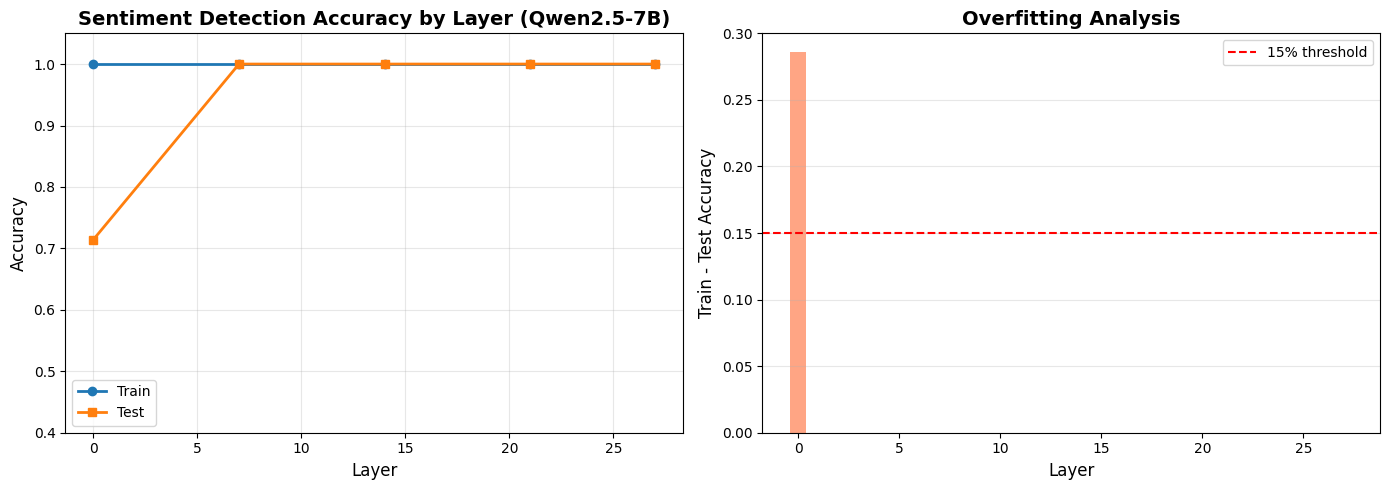


Best performing layer: 7 with 100.00% test accuracy


In [44]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by layer
ax1.plot(results['layer'], results['train_acc'], marker='o', label='Train', linewidth=2)
ax1.plot(results['layer'], results['test_acc'], marker='s', label='Test', linewidth=2)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Sentiment Detection Accuracy by Layer (Qwen2.5-7B)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.4, 1.05])

# Plot 2: Train/test gap
ax2.bar(results['layer'], results['gap'], color='coral', alpha=0.7)
ax2.axhline(y=0.15, color='red', linestyle='--', label='15% threshold')
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Train - Test Accuracy', fontsize=12)
ax2.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('qwen_sentiment_probe_layer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

best_layer = results.loc[results['test_acc'].idxmax(), 'layer']
best_acc = results.loc[results['test_acc'].idxmax(), 'test_acc']
print(f"\nBest performing layer: {best_layer} with {best_acc:.2%} test accuracy")

In [45]:
# Generalization test with different distribution
different_positive = [
    "The mentorship programme completely changed my career trajectory.",
    "I've never tasted homemade pasta this good before.",
    "Seeing my daughter graduate was the proudest moment of my life.",
    "This neighbourhood has such a wonderful sense of community.",
    "The therapist really helped me work through my anxiety.",
    "I'm blown away by how talented this band is.",
    "The renovation turned out even better than we imagined.",
    "Volunteering there has been incredibly rewarding.",
    "I finally finished the marathon and it felt amazing.",
    "The customer support team solved everything in one call.",
]

different_negative = [
    "The dentist appointment was as painful as I feared.",
    "I'm gutted that the concert got cancelled last minute.",
    "This laptop overheats constantly and crashes without warning.",
    "The landlord refuses to fix anything in this flat.",
    "I felt completely blindsided by their decision.",
    "The commute is draining the life out of me.",
    "I'm heartbroken that the relationship ended this way.",
    "The sequel completely failed to capture the original's magic.",
    "I've been struggling to sleep properly for weeks.",
    "The interview went terribly and I know I won't get the job.",
]

print(f"Different distribution: {len(different_positive)} positive, {len(different_negative)} negative")

Different distribution: 10 positive, 10 negative


In [46]:
# Train probe on original, test on different distribution
# Use the best layer from previous analysis

best_layer_idx = int(results.loc[results['test_acc'].idxmax(), 'layer'])
print(f"Using best layer: {best_layer_idx}")

# Get training data activations
X_pos_train = extractor.get_batch_activations(positive_sentences, best_layer_idx)
X_neg_train = extractor.get_batch_activations(negative_sentences, best_layer_idx)
X_train = np.vstack([X_pos_train, X_neg_train])
y_train = np.array([1] * len(positive_sentences) + [0] * len(negative_sentences))

# Train probe
probe = LogisticRegression(max_iter=1000, random_state=42)
probe.fit(X_train, y_train)
train_acc = probe.score(X_train, y_train)

# Get different distribution activations
X_pos_diff = extractor.get_batch_activations(different_positive, best_layer_idx)
X_neg_diff = extractor.get_batch_activations(different_negative, best_layer_idx)
X_diff = np.vstack([X_pos_diff, X_neg_diff])
y_diff = np.array([1] * len(different_positive) + [0] * len(different_negative))

# Test on different distribution
diff_acc = probe.score(X_diff, y_diff)

print(f"\n=== Generalization Test (Qwen2.5-7B) ===")
print(f"Training accuracy: {train_acc:.2%}")
print(f"Different distribution accuracy: {diff_acc:.2%}")
print(f"Accuracy change: {(diff_acc - train_acc):.2%}")

if diff_acc > 0.7:
    print("\n✓ Probe generalizes well! Setup verified.")
else:
    print("\n⚠ Probe generalization is weak - may need investigation.")

Using best layer: 7

=== Generalization Test (Qwen2.5-7B) ===
Training accuracy: 100.00%
Different distribution accuracy: 100.00%
Accuracy change: 0.00%

✓ Probe generalizes well! Setup verified.


### Comparison: GPT-2 (TransformerLens) vs Qwen (nnsight)

Record your results here:

| Metric | GPT-2 (Day 3-4) | Qwen2.5-7B (Today) |
|--------|-----------------|--------------------|
| Best layer | ___ | ___ |
| Best test accuracy | ___% | ___% |
| Generalization accuracy | ___% | ___% |

**Observations:**
- 
- 
- 

---

## Part 8: Troubleshooting & Success Criteria

### Common Issues

**1. Out of Memory (OOM) Errors**
- Reduce batch size (process fewer sentences at once)
- Ensure using `torch_dtype=torch.float16`
- Clear cache between operations: `torch.cuda.empty_cache()`

**2. Slow Inference**
- Check that model is on GPU: `next(model.parameters()).device`
- Use `device_map="auto"` for optimal placement
- Consider using flash attention if available

**3. Shape Mismatches**
- Qwen has 28 layers (vs GPT-2's 12)
- Qwen has 3584 hidden size (vs GPT-2's 768)
- Always check `model.config` for correct dimensions

**4. Vast.ai Specific**
- Make sure SSH is configured correctly
- Use persistent storage for model weights to avoid re-downloading
- Check that you have enough disk space (~15GB for Qwen)

In [48]:
# Success criteria verification
print("=" * 60)
print("SUCCESS CRITERIA CHECKLIST")
print("=" * 60)

checks = {
    "Model loads without OOM": True,  # If you got here, it loaded
    "Can extract activations at any layer": test_act.shape == (config.hidden_size,),
    "Activations have correct shape": test_batch.shape == (3, config.hidden_size),
    "Probe achieves >70% test accuracy": results['test_acc'].max() > 0.7,
    "Can generate text with activation access": hidden_during_gen is not None,
}

for check, passed in checks.items():
    status = "✓" if passed else "✗"
    print(f"  [{status}] {check}")

if all(checks.values()):
    print("\n" + "=" * 60)
    print("ALL CHECKS PASSED! Setup is verified.")
    print("You're ready for the CoT understanding notebook.")
    print("=" * 60)
else:
    print("\n⚠ Some checks failed. Review the issues above.")

SUCCESS CRITERIA CHECKLIST
  [✓] Model loads without OOM
  [✓] Can extract activations at any layer
  [✓] Activations have correct shape
  [✓] Probe achieves >70% test accuracy
  [✓] Can generate text with activation access

ALL CHECKS PASSED! Setup is verified.
You're ready for the CoT understanding notebook.


---

## Next Steps

Now that nnsight setup is verified, you're ready for:

1. **Understanding CoT Structure** (Day 8-9 continued)
   - Analyze how Qwen generates reasoning
   - Identify reasoning markers and structure

2. **Building CoT Dataset** (Day 8-9 continued)
   - Generate faithful/unfaithful CoT examples
   - Create evaluation framework

**Key concepts you now understand:**
- Why nnsight (not TransformerLens) for reasoning models
- How to extract activations with `.trace()` and `.save()`
- How to intervene on activations (patching)
- How to access activations during generation
- Shape differences between different module outputs

---

**Save your work and record your results!**